# Trabalho Prático 2
**Disciplina:** Inteligência Artificial (COMP0427)<br>
**Turma:** T01 - 2018.2<br>
**Orientador:** Prof. Dr. Hendrik Teixeira Macedo<br>
**Equipe:** *Ontological Entity*<br>
**Integrantes:** Airton Matheus Cardoso Leite, Eric Rocha Soares, Hugo Vinicius Dantas Barreto,<br>Igor de Figueiredo Rodrigues, Lucas Brabec Barreto Santana e Tiago Conceição dos Santos

## 1. Descrição do problema

O web site oficial da ferramenta Netica da Norsys disponibiliza diversas redes bayesianas já definidas para download (www.norsys.com/netlibrary/index.htm) em diversas categorias de conhecimento especialista: Ambiental, Médico, Financeiro/Gerencial, Geológico, Diagnóstico Industrial e Outros Industriais. Para cada uma dessas categorias, existem várias redes de exemplo com respectiva descrição da fonte explicativa do problema.

A missão é escolher uma dessas redes e proceder com um experimento em Aprendizado de Máquina, descrito a seguir:<br>
**1-** Eleger uma característica de classe;<br>
**2-** Utilizar técnica de amostragem em redes bayesianas para produzir um dataset de exemplos;<br>
**3-** Reservar parte do dataset para treinamento e parte para testes;<br>
**4-** Treinar modelo Naïve Bayes;<br>
**5-** Treinar modelo de Árvores de Decisão (ou Floresta Aleatória);<br>
**6-** Testar modelos com o conjunto de testes;<br>
**7-** Responder a algumas perguntas: O quanto cada modelo se aproxima da rede bayesiana original? O quanto o tamanho do dataset gerado influencia na qualidade? Smoothing se faz necessário? Quem possui melhor comportamento: Naïve Bayes ou Árvore de Decisão?<br>
**8-** Concluir o experimento.<br>

## 2. Solução adotada

A rede de crença bayesiana adotada, relativa ao conhecimento especialista na área médica de Pneumologia, é a que segue:<br>

![*](Chest_Clinic_Bayesian_Network.png)<br>

<br>É uma versão simplificada de uma rede que poderia ser usada para diagnosticar pacientes que chegam a uma clínica. Cada nó na rede corresponde a alguma condição do paciente. Os dois nós superiores são para predisposições que influenciam a probabilidade das doenças. Essas doenças aparecem na linha abaixo deles. Na parte inferior são sintomas das doenças. Em grande medida, os elos da rede correspondem a causação. Os links entre os nós indicam como os relacionamentos entre os nós são estruturados. Essa é uma estrutura comum para redes de diagnóstico: nós de predisposição no topo, com links para nós representando condições internas e estados de falha, que por sua vez possuem links para nós para evidenciáveis.

**1-** A característica de classe adotada foi a variável aleatória ***Tuberculosis or Cancer***, por seu tom mais dramático.

**2-** A técnica de amostragem implementada foi a ***Prior Sampling***, gerando um *dataset* inicial com 100 mil *samples*.<br>Essa abordagem é melhor explorada na seção 3.

**3-** Foi implementado script de *splitting* do dataset inicial em 66,6% para *training dataset* e 33,4% para *testing dataset*.<br>Essa abordagem é melhor explorada na seção 4.

**4-** Um modelo ***Naïve Bayes*** *baseado em distribuião gaussiana* foi inicialmente adotado. Porém a intenção é ajustá-lo para um classificador de modelos multivariados de Bernoulli, devido à natureza booleana das probabilidades da classe. Essa abordagem é melhor explorada na seção 5.

**5-** Um modelo de Floresta de Decisão Aleatória com Árvores de Decisão ensacadas com variância. Essa abordagem é melhor explorada na seção 6.

**6-** Ambos os modelos foram testados com respectivos testing datasets de 10 mil, 100 mil e 1 milhão de samples. Cada bateria de testes segue nas seções 7 e 8, para *Naïve Bayes* e *Random Decision Forest* respectivamente.

**7-** Uma breve discussão dos resultados dos testes é discorrida na seção 9.

**8-** Nossas considerações finais encerram este projeto na seção 10, seguidas pelas Referências bibliográficas.

## 3. Amostragem de dados

Os modelos probabilísticos usados são geralmente bem complexos e bastante esforço de pesquisa científica em ML é gasto no desenvolvimento de algoritmos que geram soluções aproximadas para o problema de inferência. Um método de amostragem produz respostas ao gerar repetidamente números aleatórios a partir de uma distribuição de interesse e pode ser usado para realizar consultas de inferência marginais ou de probabilidade máxima a posteriori.

O processo de amostragem prévia (Prior Sampling) é consistente e gera amostras com probabilidade: **¹Πⁿ P( Xi | Pais(Xi) )**.

In [1]:
# A node in the bayes network
class Node:
    def __init__(self, n, pa, pr):
        self.name = n
        self.parents = pa
        self.probs = pr
        self.value = None

    '''
    Returns conditional probability of value "true" for the current
    node based on the values of the parent node/s.
    '''
    def conditionalProbability(self):
        index = 0

        for i, p in enumerate(self.parents):
            if p.value == False:
                index += 2 ** (len(self.parents) - i - 1)
        return self.probs[index]

In [2]:
import random


PLAYING_EXAMPLES = [(True, False), (True, False), (True, True),
                    (True, False), (True, False), (False, True),
                    (False, False), (False, True), (False, True),
                    (False, True), (False, False), (False, True),
                    (False, True)]

class BayesNet:
    # The nodes in the network
    nodes = []

    # Build the initial network
    def __init__(self):
        self.nodes.append(Node("Visit to Asia", [], [0.01])) #index=0
        self.nodes.append(Node("Smoking", [], [0.5])) #index=1


        '''
                Visit Asia+ |   Visit asia-
            T    0.5                0.1
        '''
        self.nodes.append(Node("Tuberculosis",
                               [self.nodes[0]],
                               [0.5, 0.1])) #index=2

        '''
                Lung Cancer+ |   Lung Cancer-
        Smoking    0.10                0.01
        '''
        self.nodes.append(Node("Lung Cancer",
                               [self.nodes[1]],
                               [0.1, 0.01])) #index=3
        '''
                Bronchitis+ |   Bronchitis-
        Smoking    0.6                0.3
        '''
        self.nodes.append(Node("Bronchitis",
                               [self.nodes[1]],
                               [0.6, 0.3])) #index=4
        '''
            Tuberculosis | Lung Cancer | Tuberculosis or Cancer = True |  Tuberculosis or Cancer = False
                True            True                    1                               0
                True            False                   1                               0
                False           True                    1                               0
                False           False                   0                               1

        '''
        self.nodes.append(Node("Tuberculosis or Cancer",
                               [self.nodes[2], self.nodes[3]],
                               [1, 1, 1, 0])) #index=5


        '''
                Tuberculosis or Cancer+ | Tuberculosis or Cancer-
         XRay           0.98                        0.05
        '''
        self.nodes.append(Node("X-Ray Result", [self.nodes[5]], [0.98, 0.05])) #index=6

        '''
                    Tuberculosis or Cancer | Bronchitis | Dyspnea=True | Dyspnea=False
                            True            True               0.90             0.1
                            True            False              0.70             0.3
                            False           True               0.80             0.2
                            False           False              0.10             0.90


        '''
        self.nodes.append(Node("Dyspnea", [self.nodes[5], self.nodes[4]],
                          [0.90,0.70,0.80,0.10]))
        self.nodes.append(self.nodes.pop(5))

    # Prints the current state of the network to stdout
    def printState(self):
        strings = []
        for node in self.nodes:
            strings.append(node.name + " = " + str(node.value))

        print(", ".join(strings))

    def calculatePlayOutsideProbabilities(self, rainingInstances):
        playing = [0, 0]
        total = [0, 0]
        prob = [0.0, 0.0]

        for sample in rainingInstances:
            if sample[0]:
                playing[0] += 1 if sample[1] else 0
                total[0] += 1
            else:
                playing[1] += 1 if sample[1] else 0
                total[1] += 1

        prob[0] = float(playing[0]) / float(total[0])
        prob[1] = float(playing[1]) / float(total[1])

        return prob

    '''
    This method will sample the value for a node given its
    conditional probability.
    '''
    def sampleNode(self, node):
        node.value = True if random.random() <= node.conditionalProbability() else False

    '''
    This method assigns new values to the nodes in the network by
    sampling from the joint distribution.  Based on the PRIOR-SAMPLE
    from the text book/slides
    '''
    def priorSample(self):
        for n in self.nodes:
            self.sampleNode(n)

        return self.nodes
    '''
    This method will return true if all the evidence variables in the
    network have the value specified by the evidence values.
    '''
    def testModel(self, indicesOfEvidenceNodes, evidenceValues):
        for i in range(len(indicesOfEvidenceNodes)):
            if (self.nodes[indicesOfEvidenceNodes[i]].value != evidenceValues[i]):
                return False

        return True

    def printState(self):
        strings = []
        for node in self.nodes:
            strings.append(node.name + " = " + str(node.value))

        print(", ".join(strings))

    '''
        this method receives an number n of samples that will generate with prior sampling
        the result is an array of maps consisting of key values
        EX:
        [{Visit to Asia:False},{Smoking:False},{Tuberculosis:False},{Lung Cancer:False},{Bronchitis:True},{Tuberculosis or Cancer:False},{X-Ray Result:False},{Dyspnea:True}]
    '''
    def getSamples(self, n):
        result = []
        sublist = []
        for i in range(n):
            for node in self.priorSample():
                sublist.append({node.name: node.value})

            result.append(sublist)
            #self.printState()

        return result

    '''
        this method receives an number n of samples that will generate with prior sampling
        the result is file named sampling.txt created in the folder of tthe project with strings consisting of key values
        EX:
        {Visit to Asia:False},{Smoking:False},{Tuberculosis:False},{Lung Cancer:False},{Bronchitis:True},{Tuberculosis or Cancer:False},{X-Ray Result:False},{Dyspnea:True}

    '''
    def beginSamplingAndSaveToFile(self,numberOfSamples, filename):
        result = []
        
        for sample in range(len(numberOfSamples)):
            with open(filename+"-naive"+str(sample)+".csv", 'w'):
                    pass
            with open(filename+"-tree"+str(sample)+".csv", 'w'):
                    pass
            for i in range(numberOfSamples[sample]):
                strings = []
                strings2 = []
                for node in self.priorSample():
                    strings.append(node.name + ":" + str(node.value)) #versão para naive bayes
                    strings2.append('1' if node.value == True else '0') # versão para floresta aleatoria
                
                strings2.reverse()
                self.appendStringToFile(filename +"-naive" + str(sample) + ".csv", ",".join(strings))
                self.appendStringToFile(filename +"-tree" + str(sample)+ ".csv", ",".join(strings2))

                #self.printState()
                
        return result

    # helper method that gets a file name and a string and saves the string to the file
    def appendStringToFile(self, filename, input):
        with open(filename, 'a') as file:
                file.write(input + "\n")

if __name__ == "__main__":
    b = BayesNet() # Creates a bayes net
    # parameters of how many examples in each of the three sample archives generated for each method (six samples are generated)
    numberOfSamples = [100,1000,10000]
    nodes = b.beginSamplingAndSaveToFile(numberOfSamples,"sample")
    print("Concluido.")
    '''
    strings = []
    for node in nodes:
        for colums in node:
            strings.append(colums)

    print(strings)

    '''

Concluido.


## 4. Dataset splitting

É padrão em ML se dividir o conjunto de dados em subconjuntos de treinamento e teste. A razão para isso é que tentar avaliar o agente de aprendizado com dados já treinados é algo irrealista, o objetivo de um agente supervisionado é ser capaz de classificar dados previamente desconhecidos.

* *Esse script foi criado antes de notar que as classes de Naïve Bayes e Random Decision Forest têm funções de split próprias.*

In [3]:
# program to split the sample into training and testing datasets
import sys

# opening the files
sample = open('sample-naive2.csv','r')
#sample = open(sys.argv[1], "r")

training_dataset = open('./datasets/training_dataset.csv','w')
testing_dataset = open('./datasets/testing_dataset.csv','w')


sample_number = len(sample.readlines())
print('Total number of examples = ', sample_number)

training_cut_parameter = int(sample_number * 0.666)
print('Number of training examples = ', training_cut_parameter)
testing_cut_parameter = int(sample_number * 0.334)
print('Number of testing examples = ', testing_cut_parameter)

# return to the sample file start
sample.seek(0)

# splitting the sample into 66,6% training dataset
for example in range(training_cut_parameter):
    training_dataset.write(sample.readline())

# and 33,4% testing dataset
for example in range(testing_cut_parameter):
    testing_dataset.write(sample.readline())

# safely closing the files
sample.close()
training_dataset.close()
testing_dataset.close()


Total number of examples =  10000
Number of training examples =  6660
Number of testing examples =  3340


## 5. Naïve Bayes

O algoritmo *Naïve Bayes* é um classificador probabilístico baseado no **Teorema de Bayes** que desconsidera a correlação entre variáveis, tratando cada fator de forma independente. E leva em consideração apenas a relação de probabilidade condicional a posteriori de cada característica com o atributo de classe.

In [12]:
import csv
import random
import math

def loadCsv(filename):
    lines = csv.reader(open(filename, "r"))
    dataset = list(lines)
    for i in range(len(dataset)):
        dataset[i] = [str(x).split(':')[1] == 'True' for x in dataset[i]]
    return dataset
 
def splitDataset(dataset, splitRatio):
	trainSize = int(len(dataset) * splitRatio)
	trainSet = []
	copy = list(dataset)
	while len(trainSet) < trainSize:
		index = random.randrange(len(copy))
		trainSet.append(copy.pop(index))
	return [trainSet, copy]
 
def separateByClass(dataset):
	separated = {}
	for i in range(len(dataset)):
		vector = dataset[i]
		if (vector[-1] not in separated):
			separated[vector[-1]] = []
		separated[vector[-1]].append(vector)
	return separated
 
def mean(numbers):
	return sum(numbers)/float(len(numbers))
 
def stdev(numbers):
	avg = mean(numbers)
	variance = sum([pow(x-avg,2) for x in numbers])/float(len(numbers)-1)
	return math.sqrt(variance)
 
def summarize(dataset):
	summaries = [(mean(attribute), stdev(attribute)) for attribute in zip(*dataset)]
	del summaries[-1]
	return summaries
 
def summarizeByClass(dataset):
	separated = separateByClass(dataset)
	summaries = {}
	for classValue, instances in separated.items():
		summaries[classValue] = summarize(instances)
	return summaries

def calculateProbability(x, mean, stdev):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(1 ,2))))
    print("--- x = ",x,"\nmean = ",mean)
    print(exponent, "= e^(-", math.pow(x-mean,2),"/",(2*math.pow(1 ,2)),")")
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent
 
def calculateClassProbabilities(summaries, inputVector):
	probabilities = {}
	for classValue, classSummaries in summaries.items():
		probabilities[classValue] = 1
		for i in range(len(classSummaries)):
			mean, stdev = classSummaries[i]
			x = inputVector[i]
			probabilities[classValue] *= calculateProbability(x, mean, stdev)
	return probabilities
			
def predict(summaries, inputVector):
	probabilities = calculateClassProbabilities(summaries, inputVector)
	bestLabel, bestProb = None, -1
	for classValue, probability in probabilities.items():
		if bestLabel is None or probability > bestProb:
			bestProb = probability
			bestLabel = classValue
	return bestLabel
 
def getPredictions(summaries, testSet):
	predictions = []
	for i in range(len(testSet)):
		result = predict(summaries, testSet[i])
		predictions.append(result)
	return predictions
 
def getAccuracy(testSet, predictions):
	correct = 0
	for i in range(len(testSet)):
		if testSet[i][-1] == predictions[i]:
			correct += 1
	return (correct/float(len(testSet))) * 100.0

def runBayes(i):
    filename = 'sample-naive'+str(i)+'.csv'
    splitRatio = 0.666
    dataset = loadCsv(filename)

    trainingSet, testSet = splitDataset(dataset, splitRatio)
    summaries = summarizeByClass(trainingSet)
    predictions = getPredictions(summaries, testSet)
    accuracy = getAccuracy(testSet, predictions)
    return accuracy


### 5.1. Leitura dos dados:

In [13]:
filename = 'sample-naive0.csv'
splitRatio = 0.666
dataset = loadCsv(filename)
trainingSet, testSet = splitDataset(dataset, splitRatio)
print('Split {0} rows into train={1} and test={2} rows'.format(len(dataset), len(trainingSet), len(testSet)))

Split 100 rows into train=66 and test=34 rows


### 5.2. Aprendendo as probabilidades com Gaussian Naïve Bayes:

In [14]:
summaries = summarizeByClass(trainingSet)
print('Summary by class value: {0}'.format(summaries))

Summary by class value: {False: [(0.0, 0.0), (0.39344262295081966, 0.49256771191347115), (0.0, 0.0), (0.0, 0.0), (0.4426229508196721, 0.5008190013679071), (0.16393442622950818, 0.37328844382740006), (0.3442622950819672, 0.4790701375804083)], True: [(0.0, 0.0), (0.6, 0.5477225575051662), (0.4, 0.5477225575051662), (0.6, 0.5477225575051662), (0.6, 0.5477225575051662), (0.0, 0.0), (0.6, 0.5477225575051662)]}


### 5.3. Predições para todos os exemplos do conjunto de treinamento:

In [15]:
predictions = getPredictions(summaries, testSet)

--- x =  False 
mean =  0.0
1.0 = e^(- 0.0 / 2.0 )


ZeroDivisionError: float division by zero

### 5.4. Calculando a acurácia do modelo treinado:

In [16]:
accuracy = getAccuracy(testSet, predictions)
print('Accuracy: {0}%'.format(accuracy))

NameError: name 'predictions' is not defined

## 6. Random Decision Forest

Floresta de Decisão Aleatória configura um método de aprendizado conjunto para classificação, regressão e outras tarefas que operam construindo uma multiplicidade de árvores de decisão no momento do treinamento e gerando a classe que é a moda das classes (classificação) ou predição média (regressão) das árvores individuais. Florestas de decisão aleatórias corrigem o hábito de overfitting de árvores de decisão para seu conjunto de treinamento.

### 6.1. Gerando tabelas de contingência:

Tabela de contingência tabula dados numa matriz que exibe a distribuição de frequência (multivariada) das variáveis, fornecem uma visualização básica da inter-relação entre variáveis e podem ajudar a encontrar interações entre elas.

In [17]:
import pandas as pd
import numpy as np

print('----------------------- Features Types --------------------------')
df_sample = pd.read_csv('sample-tree0.csv', header=None)
# data types of feature/attributes in the dataset
print(df_sample.dtypes)

print('\n')
df_sample.columns = ['Tuberculosis_or_Cancer','Dyspnea','X_Ray_Result','Bronchitis',
                     'Lung_Cancer','Tuberculosis','Smoking','Visit_to_Asia']
print('Class labels:', np.unique(df_sample['Tuberculosis_or_Cancer']))
#df_sample.head()

print('------------------------------  Contingency Table 1 -------------------------------')
data_crosstab1 = pd.crosstab(df_sample['Tuberculosis_or_Cancer'], df_sample['Dyspnea'], margins = False)
print(data_crosstab1)

print('------------------------------  Contingency Table 2 -------------------------------')
data_crosstab2 = pd.crosstab([df_sample.X_Ray_Result, df_sample.Dyspnea], df_sample.Tuberculosis_or_Cancer, margins = False) 
print(data_crosstab2)

df_sample.head()

----------------------- Features Types --------------------------
0    int64
1    int64
2    int64
3    int64
4    int64
5    int64
6    int64
7    int64
dtype: object


Class labels: [0 1]
------------------------------  Contingency Table 1 -------------------------------
Dyspnea                  0   1
Tuberculosis_or_Cancer        
0                       60  31
1                        3   6
------------------------------  Contingency Table 2 -------------------------------
Tuberculosis_or_Cancer   0  1
X_Ray_Result Dyspnea         
0            0          55  3
             1          21  6
1            0           5  0
             1          10  0


,Tuberculosis_or_Cancer,Dyspnea,X_Ray_Result,Bronchitis,Lung_Cancer,Tuberculosis,Smoking,Visit_to_Asia
0,0,1,1,1,0,0,1,0
1,0,1,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0
3,0,1,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0


### 6.2 Dataset splitting into classes and features distributed in training and testing subsets:

In [18]:
#from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split

X, y = df_sample.iloc[:, 1:].values, df_sample.iloc[:, 5].values

X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=0.334, random_state=0)
print('Class: ' + df_sample.columns[0])

Class: Tuberculosis_or_Cancer


### 6.3 Random Decision Forest Algorithm 1:

Reuso do código da disponibilizado para a disicplina.

 1) Tuberculosis                   0.769301
 2) Visit_to_Asia                  0.082271
 3) Dyspnea                        0.050511
 4) Bronchitis                     0.034586
 5) Smoking                        0.025508
 6) X_Ray_Result                   0.021360
 7) Lung_Cancer                    0.000462


<IPython.core.display.Javascript object>


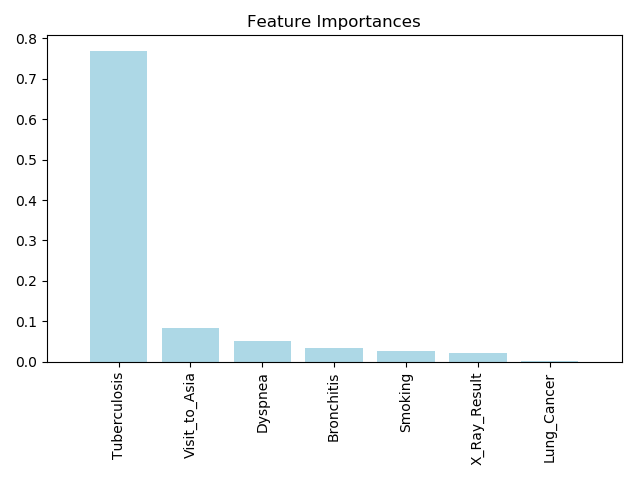

In [19]:
%matplotlib notebook

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

feat_labels = df_sample.columns[1:] # class label é o indice 1 'Tuberculosis or Cancer'


forest = RandomForestClassifier(n_estimators=10000,
                                criterion='entropy',
                                max_features='sqrt',
                                random_state=0,
                                n_jobs=-1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_


indices = np.argsort(importances)[::-1]


for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

### 6.4 Random Decision Forest Algorithm 2:

Referência externa, usando bootstrap aggregation (bagging).

In [10]:
# Random Forest Algorithm
from random import seed
from random import randrange
from csv import reader
from math import sqrt

# Load a CSV file
def load_csv(filename):
	dataset = list()
	with open(filename, 'r') as file:
		csv_reader = reader(file)
		for row in csv_reader:
			if not row:
				continue
			dataset.append(row)
	return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
	for row in dataset:
		row[column] = float(row[column].strip())

# Convert string column to integer
def str_column_to_int(dataset, column):
	class_values = [row[column] for row in dataset]
	unique = set(class_values)
	lookup = dict()
	for i, value in enumerate(unique):
		lookup[value] = i
	for row in dataset:
		row[column] = lookup[row[column]]
	return lookup

# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
	dataset_split = list()
	dataset_copy = list(dataset)
	fold_size = int(len(dataset) / n_folds)
	for i in range(n_folds):
		fold = list()
		while len(fold) < fold_size:
			index = randrange(len(dataset_copy))
			fold.append(dataset_copy.pop(index))
		dataset_split.append(fold)
	return dataset_split

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
	correct = 0
	for i in range(len(actual)):
		if actual[i] == predicted[i]:
			correct += 1
	return correct / float(len(actual)) * 100.0

# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
	folds = cross_validation_split(dataset, n_folds)
	scores = list()
	for fold in folds:
		train_set = list(folds)
		train_set.remove(fold)
		train_set = sum(train_set, [])
		test_set = list()
		for row in fold:
			row_copy = list(row)
			test_set.append(row_copy)
			row_copy[-1] = None
		predicted = algorithm(train_set, test_set, *args)
		actual = [row[-1] for row in fold]
		accuracy = accuracy_metric(actual, predicted)
		scores.append(accuracy)
	return scores

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
	left, right = list(), list()
	for row in dataset:
		if row[index] < value:
			left.append(row)
		else:
			right.append(row)
	return left, right

# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
	# count all samples at split point
	n_instances = float(sum([len(group) for group in groups]))
	# sum weighted Gini index for each group
	gini = 0.0
	for group in groups:
		size = float(len(group))
		# avoid divide by zero
		if size == 0:
			continue
		score = 0.0
		# score the group based on the score for each class
		for class_val in classes:
			p = [row[-1] for row in group].count(class_val) / size
			score += p * p
		# weight the group score by its relative size
		gini += (1.0 - score) * (size / n_instances)
	return gini

# Select the best split point for a dataset
def get_split(dataset, n_features):
	class_values = list(set(row[-1] for row in dataset))
	b_index, b_value, b_score, b_groups = 999, 999, 999, None
	features = list()
	while len(features) < n_features:
		index = randrange(len(dataset[0])-1)
		if index not in features:
			features.append(index)
	for index in features:
		for row in dataset:
			groups = test_split(index, row[index], dataset)
			gini = gini_index(groups, class_values)
			if gini < b_score:
				b_index, b_value, b_score, b_groups = index, row[index], gini, groups
	return {'index':b_index, 'value':b_value, 'groups':b_groups}

# Create a terminal node value
def to_terminal(group):
	outcomes = [row[-1] for row in group]
	return max(set(outcomes), key=outcomes.count)

# Create child splits for a node or make terminal
def split(node, max_depth, min_size, n_features, depth):
	left, right = node['groups']
	del(node['groups'])
	# check for a no split
	if not left or not right:
		node['left'] = node['right'] = to_terminal(left + right)
		return
	# check for max depth
	if depth >= max_depth:
		node['left'], node['right'] = to_terminal(left), to_terminal(right)
		return
	# process left child
	if len(left) <= min_size:
		node['left'] = to_terminal(left)
	else:
		node['left'] = get_split(left, n_features)
		split(node['left'], max_depth, min_size, n_features, depth+1)
	# process right child
	if len(right) <= min_size:
		node['right'] = to_terminal(right)
	else:
		node['right'] = get_split(right, n_features)
		split(node['right'], max_depth, min_size, n_features, depth+1)

# Build a decision tree
def build_tree(train, max_depth, min_size, n_features):
	root = get_split(train, n_features)
	split(root, max_depth, min_size, n_features, 1)
	return root

# Make a prediction with a decision tree
def predict(node, row):
	if row[node['index']] < node['value']:
		if isinstance(node['left'], dict):
			return predict(node['left'], row)
		else:
			return node['left']
	else:
		if isinstance(node['right'], dict):
			return predict(node['right'], row)
		else:
			return node['right']

# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
	sample = list()
	n_sample = round(len(dataset) * ratio)
	while len(sample) < n_sample:
		index = randrange(len(dataset))
		sample.append(dataset[index])
	return sample

# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
	predictions = [predict(tree, row) for tree in trees]
	return max(set(predictions), key=predictions.count)

# Random Forest Algorithm
def random_forest(train, test, max_depth, min_size, sample_size, n_trees, n_features):
	trees = list()
	for i in range(n_trees):
		sample = subsample(train, sample_size)
		tree = build_tree(sample, max_depth, min_size, n_features)
		trees.append(tree)
	predictions = [bagging_predict(trees, row) for row in test]
	return(predictions)

# Test the random forest algorithm
seed(2)
# load and prepare data
def runForest(i):
    filename = 'sample-tree'+str(i)+'.csv'
    dataset = load_csv(filename)
    # convert string attributes to integers
    for i in range(0, len(dataset[0])-1):
        str_column_to_float(dataset, i)
    # convert class column to integers
    str_column_to_int(dataset, len(dataset[0])-1)
    # evaluate algorithm
    n_folds = 5
    max_depth = 10
    min_size = 1
    sample_size = 1.0
    n_features = int(sqrt(len(dataset[0])-1))
    for n_trees in [1, 5, 10]:
        scores = evaluate_algorithm(dataset, random_forest, n_folds, max_depth, min_size, sample_size, n_trees, n_features)
        #print('Trees: %d' % n_trees)
        #print('Scores: %s' % scores)
        #print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))
        return (sum(scores)/float(len(scores)))
#runForest('sample-tree1.csv')

## 7. Bateria de testes para Naïve Bayes

...

## 8. Bateria de testes para Random Decision Forests

...

## 9. Discussão dos resultados

• O quanto o tamanho do dataset gerado influencia na qualidade?<br>

• Smoothing se faz necessário?<br>

• Quem possui melhor comportamento: Naïve Bayes ou Random Decision Forest?<br>


In [22]:
floresta,bayes = [],[]
for i in [1,2,3]:
    floresta.append(runForest(i))
    bayes.append(runBayes(i))
plotGraphs(tuple(bayes), tuple(floresta),[10,100,1000,100000])
    

TypeError: object of type 'int' has no len()

## 10. Considerações finais

...

## Referências

Lauritzen, Steffen L. and David J. Spiegelhalter (1988) "Local computations with probabilities on graphical structures and their application to expert systems" in J. Royal Statistics Society B, 50(2), 157-194. Online em: www.eecis.udel.edu/~shatkay/Course/papers/Lauritzen1988.pdf

RUSSEL, Stuart Jonathan; NORVIG, Peter. Artificial Intelligence: A Modern Approach. Third edition. [S.l.]:Pearson, 2009. Section 14.5.

Brownlee, Jason (2017) "How to Implement Random Forest From Scratch in Python". Online em: www.machinelearningmastery.com/implement-random-forest-scratch-python

## 6. Divisão de trabalho e checkpoints

**• Airton:** Estudo do problema, foco nas regras do Game of Life e ações do problema (GoLaD), suporte na escrita do relatório, codificação e testes.<br>
**• Eric:**   Estudo do problema, formulação inicial, estudo do Jupyter NB e do binder, formatação e escrita do relatório, codificação.<br>
**• Igor:**   Estudo do problema, formulação final, adoção de solução inicial, codificação, submissão do bot inicial para testes.<br>
**• Lucas:**  Estudo do problema, criação do repositório inicial, experienciar o game jogando e propor estratégias, codificação.<br>
**• Hugo:**  Estudo do problema, criação do repositório inicial, experienciar o game jogando e propor estratégias, codificação.<br>
**• Thiago:**  Estudo do problema, criação do repositório inicial, experienciar o game jogando e propor estratégias, codificação.
<br>- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -<br>
**12/12/2018:** Definição dos membros da equipe e do problema a ser resolvido.<br>
**13/12/2018:** Primeiras impressões sobre o problema (estudo individual analítico sobre a mecânica e contexto histórico)<br>
**18/12/2018:** Primeiras impressões sobre o problema (estudo individual analítico sobre a mecânica e contexto histórico)<br>
**20/12/2018:** Hangout de debate sobre as implicações filosóficas e impacto científico-matemático do automato celular.<br>
**21/12/2018:** Recesso declarado oficial, todos sumiram.<br>
**07/01/2019:** Volta continua do recesso, os integrantes foram aparecendo aos poucos.<br>
**08/01/2019:** Encontro presencial. Brainstorm. Definição da abordagem e técnica de IA para resolver o problema.<br>
**09/01/2019:** Divisão do trabalho entre os membros da equipe.<br>
**10/01/2019:** Tentativa de formulação do problema usando a abordagem de busca local populacional, com algoritmos genéticos.<br>
**11/01/2019:** Tentativa de formulação do problema usando a abordagem de busca local populacional, com algoritmos genéticos.<br>
**14/01/2019:** Redefinição da abordagem para busca com adversários, através da técnica de Expectiminimax e tentativa de formulação.<br>
**14/01/2019:** Redefinição da abordagem, ainda em busca com adversários, porém através da técnica de Minimax e tentativa de formulação.<br>
**15/01/2019:** Formulação.<br>
**15/01/2019:** Estudo da plataforma Anaconda e Jupyter Notebook (tutoriais e minicursos virtuais).<br>
**15/01/2019:** Inicialização de documentação no Jupyter Notebook do relatório do projeto.<br>
**15/01/2019:** Formatação inicial do documento e descrição do problema de IA escolhido.<br>
**16/01/2019:** Melhor compreensão da API da plataforma riddles.io para o Game of Life and Death e download do starter bot disponibilizado pela mesma.<br>
**16/01/2019:** Teste de submissão do robô burro na plataforma riddles.io para competir com outros robôs.<br>
**16/01/2019:** Instalação do PyCharm IDE e criação do repositório inicial no GitHub para codificação da solução adotada.<br>
**16/01/2019:** Estudo da plataforma Binder para emular o servidor do Jupyter Notebook online (tutoriais).<br>
**16/01/2019:** Escrita do relatório.<br>
**17/01/2019:** Escrita do relatório.<br>
**17/01/2019:** Estudo dos códigos disponibilizados para a disciplina.<br>
**17/01/2019:** Implementação.<br>
**18/01/2019:** Estudo dos códigos disponibilizados para a disciplina.<br>
**18/01/2019:** Implementação.<br>
**19/01/2019:** Estudo dos códigos disponibilizados para a disciplina.<br>
**19/01/2019:** Implementação.<br>
**19/01/2019:** Teste de submissão da solução adotada na plataforma riddles.io para competir com outros robôs.<br>
**20/01/2019:** Estudo dos códigos disponibilizados para a disciplina.<br>
**20/01/2019:** Implementação.<br>
**20/01/2019:** Teste de submissão da solução adotada na plataforma riddles.io para competir com outros robôs.<br>
**21/01/2019:** Implementação, testes finais e entrada.<br>

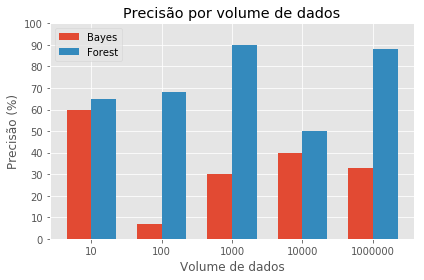

In [20]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
# Graficos mostrados direto do notebook
%matplotlib inline

# Definir estilo com template
plt.style.use("ggplot")

def plotGraphs(bayes,forest,n):
    # Dados
    #bayes, bayes_std = (60, 70, 30), (2, 3, 4)
    #forest, forest_std = (65, 68, 90), (3, 5, 2)

    # Criar um vetor de índices (1,2,3...,n) com n elementos
    ind = np.arange(len(bayes))
    # Tamanho das barras (padrão)
    width = 0.35
    
    n = tuple(n)
    # Números para os pontos
    #ticks = []
    #a,b = 0,1
    #for i in range(len(bayes)):
    #    ticks.append(str(10**(a+b)))
    #    a,b = b,a+b
    #ticks = tuple(ticks)
    # Criar gráfico
    fig, ax = plt.subplots()

    # Adicionar componentes ao gráfico
    #rects1 = ax.bar(ind - width/2, bayes, width, yerr=bayes_std, label='Bayes')
    rects1 = ax.bar(ind - width/2, bayes, width, label='Bayes')
    #rects2 = ax.bar(ind + width/2, forest, width, yerr=forest_std, label='Forest')
    rects2 = ax.bar(ind + width/2, forest,width, label='Forest')

    # Títulos no grafico e nos eixos
    ax.set_title('Precisão por volume de dados')
    ax.set_ylabel('Precisão (%)')
    ax.set_xlabel('Volume de dados')
    #Número de pontos no eixo X
    ax.set_xticks(ind) 
    # Número de pontos no eixo Y
    ax.set_yticks(np.arange(0, 101, 10)) 
    # Editar os rótulos dos pontos do eixo
    #ax.set_xticklabels(ticks)
    ax.set_xticklabels(n)
    # Adicionar legenda
    ax.legend()
    fig.tight_layout()
    plt.show()


bayes  = (60, 7, 30, 40,33)
forest = (65, 68, 90, 50,88)
plotGraphs(bayes,forest,[10,100,1000,10000,1000000])





